# **Data Clocking Prediction based on the form/no form classification**

In [ ]:
import zipfile
import os

zip_file_path = '/content/CDT_Clock_JPG.zip'
unzip_dir = 'unzipped_data'

os.makedirs(unzip_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

UNZIP_DIR = os.path.abspath(unzip_dir)
print(f"ZIP file extracted to: {UNZIP_DIR}")

ZIP file extracted to: /content/unzipped_data


In [ ]:
import os

# Construct the path to the main unzipped directory
main_unzipped_dir = os.path.join(UNZIP_DIR, 'CDT_Clock_JPG')

# Verify if the main directory exists
if not os.path.isdir(main_unzipped_dir):
    print(f"Error: Main unzipped directory '{main_unzipped_dir}' not found.")
else:
    print(f"Main unzipped directory found: {main_unzipped_dir}")

    # List contents of the main unzipped directory
    dir_contents = os.listdir(main_unzipped_dir)
    print(f"Contents of '{main_unzipped_dir}': {dir_contents}")

    # Check for 'form' and 'no_form' subdirectories
    form_dir = os.path.join(main_unzipped_dir, 'form')
    no_form_dir = os.path.join(main_unzipped_dir, 'No_form') # Corrected according to file list

    form_exists = os.path.isdir(form_dir)
    no_form_exists = os.path.isdir(no_form_dir)

    print(f"'form' directory exists: {form_exists}")
    print(f"'no_form' directory exists: {no_form_exists}")

    if form_exists and no_form_exists:
        print("All required directories ('CDT_Clock_JPG', 'form', 'no_form') are present and correctly structured.")
    else:
        print("Missing one or both of the 'form' or 'no_form' directories.")

Main unzipped directory found: /content/unzipped_data/CDT_Clock_JPG
Contents of '/content/unzipped_data/CDT_Clock_JPG': ['No_form', 'form']
'form' directory exists: True
'no_form' directory exists: True
All required directories ('CDT_Clock_JPG', 'form', 'no_form') are present and correctly structured.


In [ ]:
import os

# Initialize sets to store unique extensions
form_extensions = set()
no_form_extensions = set()

# Iterate through files in 'form' directory
for filename in os.listdir(form_dir):
    _, ext = os.path.splitext(filename)
    if ext:
        form_extensions.add(ext.lower())

# Iterate through files in 'no_form' directory
for filename in os.listdir(no_form_dir):
    _, ext = os.path.splitext(filename)
    if ext:
        no_form_extensions.add(ext.lower())

print(f"Unique file extensions in 'form' directory: {form_extensions}")
print(f"Unique file extensions in 'no_form' directory: {no_form_extensions}")

Unique file extensions in 'form' directory: {'.jpg'}
Unique file extensions in 'no_form' directory: {'.jpg'}


In [ ]:
# ============================================
# 0. CONFIG & IMPORTS
# ============================================

import os
from pathlib import Path
import shutil
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

# Root folder where your 200 images live, in two subfolders: form, no_form
# Example: /content/CDT_Clock_200 with:
#   /content/CDT_Clock_200/form
#   /content/CDT_Clock_200/no_form
DATA_ROOT = Path(UNZIP_DIR) / "CDT_Clock_JPG"   # <-- change this if needed

IMG_SIZE = (224, 224)
BATCH_SIZE = 16           # smaller batch for small dataset
AUTOTUNE = tf.data.AUTOTUNE

CLASS_NAMES = ["no_form", "form"]
CLASS_TO_LABEL = {"no_form": 0, "form": 1}
VALID_EXTS = (".jpg", ".jpeg", ".png", ".tif", ".tiff")


TensorFlow version: 2.19.0


In [ ]:
# ============================================
# 1. VERIFY 'form' AND 'no_form' FOLDERS
# ============================================

form_dir = DATA_ROOT / "form"
no_form_dir = DATA_ROOT / "No_form" # Corrected to match the actual folder name 'No_form'

if not form_dir.exists() or not no_form_dir.exists():
    raise RuntimeError(f"ERROR: Expected subfolders 'form' and 'No_form' under {DATA_ROOT}.")

form_files = [f for f in os.listdir(form_dir) if f.lower().endswith(VALID_EXTS)]
no_form_files = [f for f in os.listdir(no_form_dir) if f.lower().endswith(VALID_EXTS)]

if len(form_files) == 0:
    raise RuntimeError("ERROR: 'form' folder is empty or has no valid images.")
if len(no_form_files) == 0:
    raise RuntimeError("ERROR: 'No_form' folder is empty or has no valid images.")

print(f"'form' images   : {len(form_files)}")
print(f"'no_form' images: {len(no_form_files)}")
print("Sample 'form'   :", form_files[:5])
print("Sample 'no_form':", no_form_files[:5])

'form' images   : 100
'no_form' images: 100
Sample 'form'   : ['10004757.jpg', '10006608.jpg', '10005201.jpg', '10007218.jpg', '10006784.jpg']
Sample 'no_form': ['40014224.jpg', '40013127.jpg', '40014288.jpg', '40011637.jpg', '40013368.jpg']


In [ ]:
# ============================================
# 2. BUILD PATH/LABEL LIST AND SPLIT
# ============================================

all_paths = []
all_labels = []

# no_form -> 0
for fname in no_form_files:
    all_paths.append(str(no_form_dir / fname))
    all_labels.append(CLASS_TO_LABEL["no_form"])

# form -> 1
for fname in form_files:
    all_paths.append(str(form_dir / fname))
    all_labels.append(CLASS_TO_LABEL["form"])

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("\nTotal images:", len(all_paths))
unique, counts = np.unique(all_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u} ({CLASS_NAMES[u]}): {c} images")

# 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    all_paths,
    all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.50,
    stratify=y_tmp,
    random_state=42
)

print("\nSplit sizes:")
print("Train:", len(X_train))
print("Val  :", len(X_val))
print("Test :", len(X_test))



Total images: 200
Label 0 (no_form): 100 images
Label 1 (form): 100 images

Split sizes:
Train: 140
Val  : 30
Test : 30


In [ ]:
# ============================================
# 3. CREATE PHYSICAL SPLIT FOLDERS (OPTIONAL BUT ROBUST)
# ============================================

SPLIT_ROOT = Path("split_data")

# Clean previous splits
if SPLIT_ROOT.exists():
    shutil.rmtree(SPLIT_ROOT)

for split in ["train", "val", "test"]:
    for cname in CLASS_NAMES:
        (SPLIT_ROOT / split / cname).mkdir(parents=True, exist_ok=True)

def copy_to_split(paths, labels, split_name):
    for p, lab in zip(paths, labels):
        src = Path(p)
        cls_name = CLASS_NAMES[lab]
        dst = SPLIT_ROOT / split_name / cls_name / src.name
        shutil.copy2(src, dst)

copy_to_split(X_train, y_train, "train")
copy_to_split(X_val,   y_val,   "val")
copy_to_split(X_test,  y_test,  "test")

print(f"\nPhysical split created under: {SPLIT_ROOT}")



Physical split created under: split_data


In [ ]:
# ============================================
# 3.1 VERIFY SPLIT FOLDERS ARE NOT EMPTY
# ============================================

def count_images(folder: Path):
    return len([f for f in os.listdir(folder) if f.lower().endswith(VALID_EXTS)])

for split in ["train", "val", "test"]:
    for cname in CLASS_NAMES:
        folder = SPLIT_ROOT / split / cname
        if not folder.exists():
            raise RuntimeError(f"ERROR: Missing folder: {folder}")
        n = count_images(folder)
        if n == 0:
            raise RuntimeError(f"ERROR: Empty folder: {folder}")
        print(f"{folder} -> {n} images")

print("\nAll split folders are non-empty. Good to proceed.")


split_data/train/no_form -> 70 images
split_data/train/form -> 70 images
split_data/val/no_form -> 15 images
split_data/val/form -> 15 images
split_data/test/no_form -> 15 images
split_data/test/form -> 15 images

All split folders are non-empty. Good to proceed.


In [ ]:
# ============================================
# 4. TF.DATA PIPELINES (GRAYSCALE + AUGMENTATION)
# ============================================

def load_and_preprocess(path, label):
    # Read image
    img_bytes = tf.io.read_file(path)
    # Decode as single-channel (grayscale)
    img = tf.image.decode_image(img_bytes, channels=1, expand_animations=False)
    img.set_shape([None, None, 1])

    # Convert to float32 (0–255 range after resize)
    img = tf.cast(img, tf.float32)

    # Slight contrast boost (tuned for black strokes)
    img = tf.image.adjust_contrast(img, 1.5)

    # Resize
    img = tf.image.resize(img, IMG_SIZE)

    # Tile grayscale to 3 channels for ResNet50 (H, W, 1) -> (H, W, 3)
    img = tf.tile(img, [1, 1, 3])

    return img, label


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)


def make_dataset_from_split(split_name, training=False):
    paths = []
    labels = []
    for cname, lab in CLASS_TO_LABEL.items():
        folder = SPLIT_ROOT / split_name / cname
        for fname in os.listdir(folder):
            if fname.lower().endswith(VALID_EXTS):
                paths.append(str(folder / fname))
                labels.append(lab)

    paths = np.array(paths)
    labels = np.array(labels)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset_from_split("train", training=True)
val_ds   = make_dataset_from_split("val",   training=False)
test_ds  = make_dataset_from_split("test",  training=False)

batch_imgs, batch_labels = next(iter(train_ds))
print("\nSample batch shapes:")
print("Images:", batch_imgs.shape)   # (B, 224, 224, 3)
print("Labels:", batch_labels.shape)
print("First labels:", batch_labels.numpy()[:10])



Sample batch shapes:
Images: (16, 224, 224, 3)
Labels: (16,)
First labels: [0 1 1 0 1 0 1 1 0 0]


In [ ]:
# ============================================
# 5. RESNET50-BASED MODEL (TRANSFER LEARNING)
# ============================================

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# Preprocess layer for ResNet50
preprocess_layer = layers.Lambda(preprocess_input, name="preprocess_input")

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
)

# First, freeze the backbone
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,), name="clock_image")

x = preprocess_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

model = keras.Model(inputs, outputs, name="resnet50_clock_classifier")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "resnet50_clock_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ clock_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess_input (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ============================================
# 6. CALLBACKS
# ============================================

checkpoint_path = "best_resnet50_clock_model.h5"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
    ),
]


In [ ]:
# ============================================
# 7. TRAINING - PHASE 1 (FROZEN BACKBONE)
# ============================================

EPOCHS_PHASE1 = 20

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5957 - loss: 0.7907

9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.6026 - loss: 0.7787 - val_accuracy: 0.7667 - val_loss: 0.4110
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8522 - loss: 0.3845

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8570 - loss: 0.3769 - val_accuracy: 0.9333 - val_loss: 0.2376
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9502 - loss: 0.1815 - val_accuracy: 0.9000 - val_loss: 0.2885
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9436 - loss: 0.1793

9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9450 - loss: 0.1782 - val_accuracy: 0.9333 - val_loss: 0.2085
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9794 - loss: 0.1119

9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.9779 - loss: 0.1134 - val_accuracy: 0.9333 - val_loss: 0.1428
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9847 - loss: 0.1145 - val_accuracy: 0.9333 - val_loss: 0.1531
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9761 - loss: 0.0883

9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9756 - loss: 0.0882 - val_accuracy: 0.9667 - val_loss: 0.1129
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9573 - loss: 0.1036

9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9580 - loss: 0.1040 - val_accuracy: 0.9667 - val_loss: 0.1051
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9946 - loss: 0.0520 - val_accuracy: 0.9667 - val_loss: 0.1225
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9893 - loss: 0.0535 - val_accuracy: 0.9333 - val_loss: 0.1751
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9751 - loss: 0.0642

9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9762 - loss: 0.0640 - val_accuracy: 1.0000 - val_loss: 0.0789
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9590 - loss: 0.1032

9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9595 - loss: 0.1018 - val_accuracy: 1.0000 - val_loss: 0.0561
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9823 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 0.0742
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9964 - loss: 0.0496 - val_accuracy: 0.9667 - val_loss: 0.0910
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9838 - loss: 0.0627

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9833 - loss: 0.0629 - val_accuracy: 1.0000 - val_loss: 0.0500
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9601 - loss: 0.0915 - val_accuracy: 1.0000 - val_loss: 0.0633
Epoch 17/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9794 - loss: 0.0672 - val_accuracy: 1.0000 - val_loss: 0.0807
Epoch 18/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9873 - loss: 0.0597

9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9878 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 0.0483
Epoch 19/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9876 - loss: 0.0370 - val_accuracy: 1.0000 - val_loss: 0.0557
Epoch 20/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9788 - loss: 0.0424 - val_accuracy: 1.0000 - val_loss: 0.0501


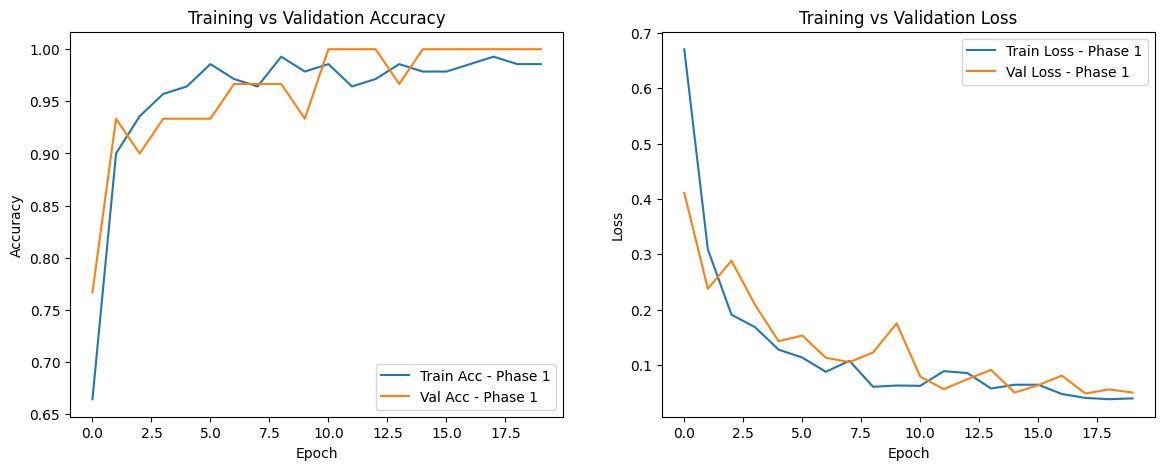

In [ ]:
# ============================================
# OVERFITTING DIAGNOSTICS (PLOT ACCURACY & LOSS)
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='Train Acc - Phase 1')
plt.plot(history_1.history['val_accuracy'], label='Val Acc - Phase 1')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='Train Loss - Phase 1')
plt.plot(history_1.history['val_loss'], label='Val Loss - Phase 1')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

True labels for these samples: [0 0 0 0 1 1 1 1]
Predicted labels for these samples: [0 0 0 0 1 1 1 1]


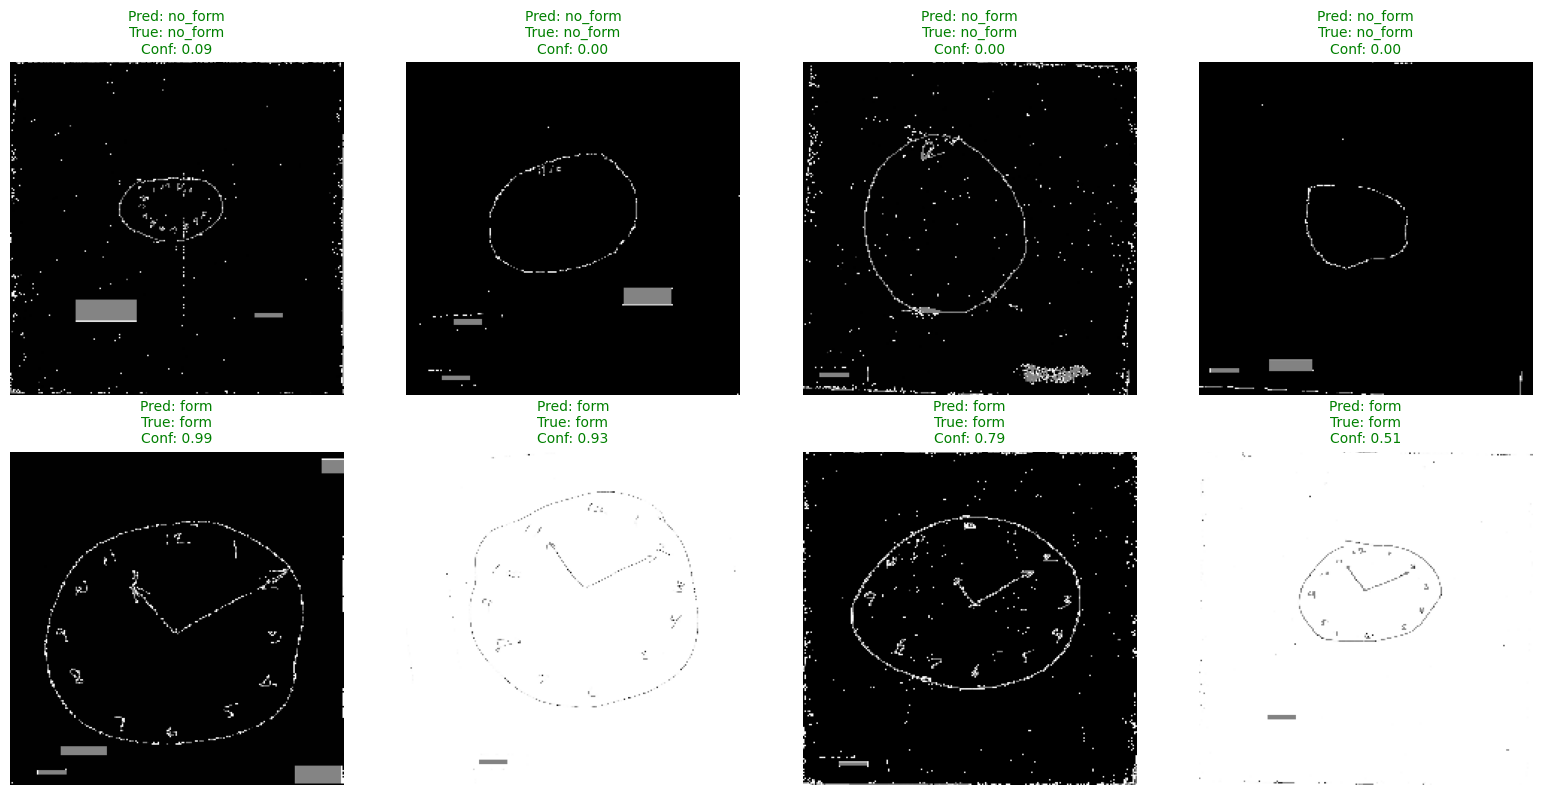

In [74]:

# ============================================
# 7. Visualization Sample
# ============================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get indices for 'form' and 'no_form' in the test set
no_form_test_indices = np.where(y_test == CLASS_TO_LABEL['no_form'])[0]
form_test_indices = np.where(y_test == CLASS_TO_LABEL['form'])[0]

# Number of samples to display from each class
num_samples_per_class = 4

# Randomly select sample indices from each class
np.random.seed(42) # for reproducibility
selected_no_form_indices = np.random.choice(no_form_test_indices, min(num_samples_per_class, len(no_form_test_indices)), replace=False)
selected_form_indices = np.random.choice(form_test_indices, min(num_samples_per_class, len(form_test_indices)), replace=False)

# Combine paths and labels for selected samples
sample_paths = []
sample_labels = []

for idx in selected_no_form_indices:
    sample_paths.append(X_test[idx])
    sample_labels.append(y_test[idx])

for idx in selected_form_indices:
    sample_paths.append(X_test[idx])
    sample_labels.append(y_test[idx])

sample_paths = np.array(sample_paths)
sample_labels = np.array(sample_labels)

# Create a TensorFlow dataset for these samples and preprocess them
sample_ds = tf.data.Dataset.from_tensor_slices((sample_paths, sample_labels))
sample_ds = sample_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
sample_ds = sample_ds.batch(len(sample_paths)).prefetch(AUTOTUNE)

# Get the preprocessed images and true labels
preprocessed_images, true_sample_labels = next(iter(sample_ds))

# Make predictions
pred_probs = model.predict(preprocessed_images, verbose=0).ravel()
pred_sample_labels = (pred_probs >= 0.5).astype(int)

print(f"True labels for these samples: {true_sample_labels.numpy()}")
print(f"Predicted labels for these samples: {pred_sample_labels}")

# Visualize the predictions
num_samples_to_display = len(sample_paths)
plt.figure(figsize=(16, 4 * ((num_samples_to_display + 3) // 4)))

for i in range(num_samples_to_display):
    img = preprocessed_images[i].numpy().astype("uint8")
    true_label = CLASS_NAMES[true_sample_labels[i].numpy()]
    pred_label = CLASS_NAMES[pred_sample_labels[i]]
    confidence = pred_probs[i]

    plt.subplot((num_samples_to_display + 3) // 4, 4, i + 1)
    plt.imshow(img)
    color = "green" if true_label == pred_label else "red"
    plt.title(
        f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.2f}",
        fontsize=10,
        color=color
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


Total Accuracy on Test Set: 0.9333

Confusion Matrix:
[[15  0]
 [ 2 13]]


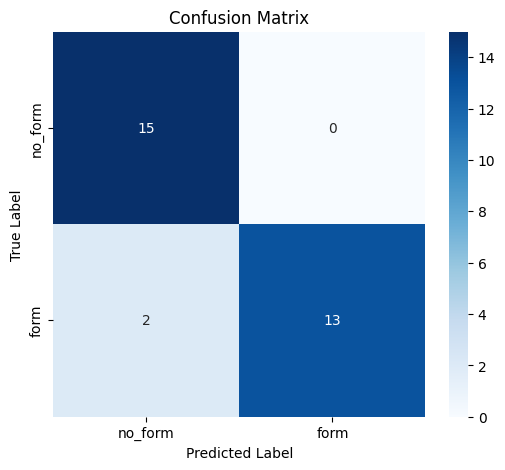


Classification Report:
              precision    recall  f1-score   support

     no_form       0.88      1.00      0.94        15
        form       1.00      0.87      0.93        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [75]:
# ============================================
# 8. Overall Acuraccy
# ============================================
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate overall accuracy
total_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTotal Accuracy on Test Set: {total_accuracy:.4f}")

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Display Confusion Matrix visually
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
class_report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print("\nClassification Report:")
print(class_report)